# Molecular dynamics simulations of a water slab

In this example, we will try to perform molecular dynamics of a water slab using the simple interatomic TIP3P potential
([W. L. Jorgensen et. al.](https://doi.org/10.1063/1.445869)) and [LAMMPS](http://lammps.sandia.gov/)

## Creating the initial structure

In the field of computational electrochemistry, the study of metal/water interfaces are very important. We would therefore like to create slabs that are commensurable with the metal slab (in the lateral directions). In this example, we would use the orthogonal 3$\times$4 Mg(0001) surface slab as a reference to set the lateral dimensions of our water slab

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pylab as plt
from pyiron_atomistics.structure.atoms import Atoms
from pyiron_atomistics.structure.periodic_table import PeriodicTable
from pyiron.project import Project
import matplotlib
import ase.units as units
import pandas as pd
from numpy import in1d

In [2]:
pr = Project("tip3p_water")

In [3]:
a = 3.19158
c = 5.18504

# Dummy Mg0001 lattice
Mg_0001 = pr.create_surface(element="Mg", size=(3, 4, 3), surface_type="hcp0001", a=a, c=c, orthogonal=True, vacuum=10)


Now we define a function that creates a water slab and the interface based on the required dimensions of the metal slab, the number of water molecules required and the density of the water slab. We create a very approximate structure in the beginning

In [4]:
def setup_water_interface(surface, n_water=16, density=1.0, both_sides=True, intermediate_vacuum=1.5):
        density *= 1.0e6  # g/m3
        mass = 18.015 / units.mol  # g
        vol_h2o = mass / density * 1e30  # angstrom ^3
        scaling_factor = (surface.get_volume() / vol_h2o)
        cell = surface.cell.copy()
        cell[2] *= scaling_factor
        length = np.linalg.norm(cell[2])
        dx = 0.7
        r_O = [0, 0, 0]
        r_H1 = [dx, dx, 0]
        r_H2 = [-dx, dx, 0]
        n = int(round(n_water ** (1. / 3.)))
        reduced_cell =  np.abs(cell) ** (1. / n, 1. / n, 1. / n )
        water = Atoms(elements=['H', 'H', 'O'], positions=[r_H1, r_H2, r_O], cell=reduced_cell)
        water.set_repeat((n, n, n))
        water.set_relative()
        water.cell[0:2] = surface.cell[0:2].copy()
        water_mass = np.average(water.get_masses()) * len(water) / units.mol
        reqd_volume = water_mass / density * 1e30
        scaling_factor = (reqd_volume / water.get_volume())
        # Setting relative coordinates so that the positions also scale with the cell size
        water.set_relative()
        water.cell[2, 2] *= scaling_factor
        length = np.linalg.norm(water.cell[2])
        print("Density in g/cc:", water_mass / water.get_volume() * 1e24)
        water.set_absolute()
        water_structure = water.copy()
        surface.set_absolute()
        if both_sides:
            d = water.cell[2, 2] - np.max(water.positions[:, 2])
            total_length = 2 * np.max(surface.positions[:, 2]
                                     ) + water.cell[2, 2] + (2* intermediate_vacuum)
            surface_left = surface.copy()
            surface_left.set_absolute()
            surface_left.cell[2, 2] = total_length
            water.cell[2, 2] = total_length
            water.positions[:, 2] += np.max(surface_left.positions[:, 2]
                                           ) +  2 * intermediate_vacuum
            basis = surface_left + water 
            surface_right = surface_left.copy()
            surface_right.positions[:, 2] += np.max(basis.positions[:, 2]) + d 
            basis += surface_right
        else:
            total_length = np.max(surface.positions[:, 2]) + np.max(
                water.positions[:, 2]) + 2* intermediate_vacuum
            surface_left = surface.copy()
            surface_left.set_absolute()
            surface_left.cell[2, 2] = total_length
            water.cell[2, 2] = total_length
            water.positions[:, 2] += np.max(surface_left.positions[:, 2]
                                           ) + intermediate_vacuum
            basis = surface_left + water
        return basis, water_structure

In [5]:
struct, water_structure = setup_water_interface(surface=Mg_0001, n_water=64, density=1.0, 
                                                both_sides=True, intermediate_vacuum=1.)
water_indices = np.append(struct.select_index("H"), struct.select_index("O"))
view = water_structure.plot3d()
view

Density in g/cc: 1.0


NGLWidget()

## Dynamics using a small time step

The instance `struct` is the metal/water interface which we will ignore for now . The initial structure in this simulation is obviously a very poor starting point for our calculations. However, dynamics using a small time-step will help us generate a structure which resembles that of water/ice. We will use the NVT ensemble for this calculation

In [6]:
temp = 300
steps = 1e5
time_step = 0.01 # fs

In [7]:
job_name = "water_slow".format(str(int(temp)))
ham = pr.create_job("Lammps", job_name)
ham.structure = water_structure
# Listing available potentials for this structure
ham.list_potentials()

['H2O_tip3p', 'H2O_tip3p_slab']

We will use the `H2O_tip3p` potential. The `H2O_tip3p_slab` should be used if you want to switch the periodic boundary conditions along the z-axis  

In [8]:
ham.potential = 'H2O_tip3p'

In [9]:
ham.calc_md(temperature=temp, n_ionic_steps=steps, n_print=1000, dt=time_step)

In [10]:
ham.run()

In [11]:
view = ham.animate_structure()
view

NGLWidget(count=101)

## Faster dynamics

We have obtained a structure that at least resembles a slab of water molecules. Now we can increase the time step to perform dynamics to get a reasonably equilibriated structure 

In [12]:
# Get the final structure
struct = ham.get_structure(iteration_step=-1)
# Fold the atoms back into the unitcell
struct.center_coordinates_in_unit_cell() 
time_step = 1
steps = 1e5
job_name = "water_fast".format(str(int(temp)))
ham_fast = pr.create_job("Lammps", job_name)
ham_fast.structure = struct
ham_fast.potential = 'H2O_tip3p'
n_print = 10 # output every n_print steps
ham_fast.calc_md(temperature=temp, n_ionic_steps=steps, n_print=n_print, dt=time_step)
ham_fast.run()

In [13]:
view = ham_fast.animate_structure()
view

NGLWidget(count=10001)

We can now plot the trajectories

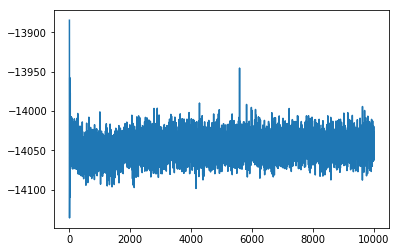

In [14]:
plt.plot(ham_fast["output/generic/energy_tot"])

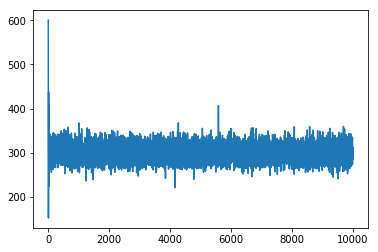

In [15]:
plt.plot(ham_fast["output/generic/temperatures"])

## Computing neighbors and further analysis

We will now use the `get_neighbors()` function to compute structural properties during the course of the simulation. We take advantage of the fact that the TIP3P water model is a rigid water model which means the neighbors need to be indexed only once

In [16]:
final_struct = ham_fast.get_structure(iteration_step=-1)

# Get the indices based on species
O_indices = final_struct.select_index("O")
H_indices = final_struct.select_index("H")

# Getting only the first two neighbors
neighbors = final_struct.get_neighbors(num_neighbors=2)

### Distribution of the O-H bond length

The immediate two neighbors of every O atom has to be H atoms

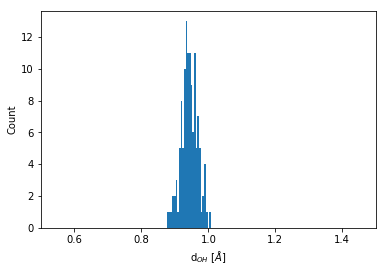

In [17]:
bins = np.linspace(0.5, 1.5, 200)
_ = plt.hist(np.hstack(neighbors.distances[O_indices]), bins=bins)
plt.xlim(0.5, 1.5)
plt.xlabel("d$_{OH}$ [$\AA$]")
plt.ylabel("Count");

## Distribution of the O-O bond lengths

Here we need to compute more neighbors than the nearest 2. We could also do this using a cutoff distance

In [18]:
neighbors = final_struct.get_neighbors(cutoff=8)

In [19]:
neigh_indices = np.hstack(neighbors.indices[O_indices])
neigh_distances = np.hstack(neighbors.distances[O_indices])

We now need only the distances between the O atoms. We can exclude the H atoms using a few simple index manipulation steps

In [20]:
O_neigh_indices  = in1d(neigh_indices, O_indices)
O_neigh_distances = neigh_distances[O_neigh_indices]

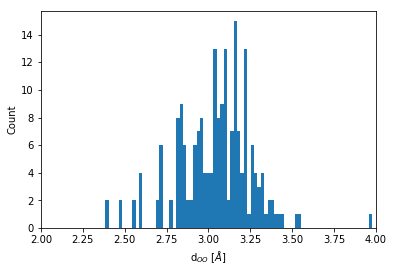

In [21]:
bins = np.linspace(2, 4, 100)
count = plt.hist(O_neigh_distances, bins=bins)
plt.xlim(2, 4)
plt.xlabel("d$_{OO}$ [$\AA$]")
plt.ylabel("Count");